In [124]:
!pip install tweepy apyori networkx

import pandas as pd
import tweepy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from lib import progress_bar
import json
import re
from konlpy.tag import Okt
from collections import Counter
from apyori import apriori

import warnings
warnings.filterwarnings("ignore")

In [120]:
CONSUMER_KEY = "{YOUR_API_KEY}"
CONSUMER_SECRET = "{YOUR_API_SECRET_KEY}"
ACCESS_TOKEN_KEY = "{YOUR_ACCESS_TOKEN}"
ACCESS_TOKEN_SECRET = "{YOUR_ACCESS_TOKEN_SECRET}"
  
# Opening JSON file
with open('api_config.json','r') as f:
    config = json.load(f)
    CONSUMER_KEY = config['CONSUMER_KEY']
    CONSUMER_SECRET = config['CONSUMER_SECRET']
    ACCESS_TOKEN_KEY = config['ACCESS_TOKEN_KEY']
    ACCESS_TOKEN_SECRET = config['ACCESS_TOKEN_SECRET']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [34]:
KEYWORD = "{SOME_KEYWORD}" # Keyword we want to analyze using Twitter API

Collect Data using Twitter API

In [108]:

tweets = api.search(KEYWORD)
columns = ['created', 'tweet_text']
df = pd.DataFrame(columns = columns)
print("Getting Data...")
dataSize = 100
for i in range(dataSize):
    tweets = api.search(KEYWORD)
    for tweet in tweets:
        tweet_text = tweet.text
        created = tweet.created_at
        row = [created, tweet_text]
        series = pd.Series(row, index = df.columns)
        df = df.append(series, ignore_index = True)
    progress_bar.progress_bar(i, dataSize)
progress_bar.progress_bar(dataSize, dataSize)
print("\nGetting Data Completed...")
df.head(3)

Getting Data...
[====================================================================================================] 100%
Getting Data Completed...


Extract Keywords

In [85]:
def text_cleaning(text):
    # Use one of the regexes below 
    # if you want to make one for your own language:
    #   A = (First letter)
    #   B = (Last letter)
    #   C = (First capital letter) if there is one
    #   D = (Last capital letter) if there is one
    # If your language supports combination of letters (syllable)
    # as one character like Korean, Chinese, or etc
    #   E = (First possible combination)
    #   F = (First possible combination)
    # Use '[^ A-BC-DE-F]+' as your regular expression
    regex = re.compile('[^ A-Za-z]+') # For English
    regex = re.compile('[^ ㄱ-ㅣ가-힣]+') # For Korean
    result = regex.sub('', text)
    return result

df['clean_text'] = df['tweet_text'].apply(lambda x : text_cleaning(x))
df.head()

,created,tweet_text,ko_text
0,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...
1,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...
2,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...
3,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...
4,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...


In [123]:
# Other languages' stopwords available here: https://www.ranks.nl/stopwords
stopwords_path = "data/english_stopwords.txt" # For English
stopwords_path = "data/korean_stopwords.txt" # For Korean

with open(stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

In [89]:
def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    nouns = [noun for noun in nouns if len(noun) > 1] # Remove single character words
    nouns = [noun for noun in nouns if noun not in stopwords] # Remove stopwords
    return nouns

(78, 4)


,created,tweet_text,ko_text,nouns
0,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...,"[화정, 고딩, 축픽, 태그, 구룡, 부여, 위신, 영리, 스웨디시, 마사지, 살색..."
1,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...,"[화정, 고딩, 축픽, 태그, 구룡, 부여, 위신, 영리, 스웨디시, 마사지, 살색..."
2,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...,"[화정, 고딩, 축픽, 태그, 구룡, 부여, 위신, 영리, 스웨디시, 마사지, 살색..."
3,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...,"[화정, 고딩, 축픽, 태그, 구룡, 부여, 위신, 영리, 스웨디시, 마사지, 살색..."
4,2021-08-03 03:03:52,화정\n여고딩\n일탈\n해축픽\n태그\n살빼는중\n구룡\n부여쯔위\n신영리\n펠라 ...,화정여고딩일탈해축픽태그살빼는중구룡부여쯔위신영리펠라 스웨디시마사지살색계금촌헤드헌터 애...,"[화정, 고딩, 축픽, 태그, 구룡, 부여, 위신, 영리, 스웨디시, 마사지, 살색..."


In [ ]:
df['nouns'] = df['clean_text'].apply(lambda x : get_nouns(x))
print(df.shape)
df.head(3)

In [94]:
transactions = df['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction]
print(transactions[:3])

[['화정', '고딩', '축픽', '태그', '구룡', '부여', '위신', '영리', '스웨디시', '마사지', '살색', '금촌', '헤드헌터', '애무', '오랄', '성인', '익산', '콜걸', '술함', '설산', '세종', '강원', '강남', '순천', '이영애', '손흥민', '코스', '투자'], ['화정', '고딩', '축픽', '태그', '구룡', '부여', '위신', '영리', '스웨디시', '마사지', '살색', '금촌', '헤드헌터', '애무', '오랄', '성인', '익산', '콜걸', '술함', '설산', '세종', '강원', '강남', '순천', '이영애', '손흥민', '코스', '투자'], ['화정', '고딩', '축픽', '태그', '구룡', '부여', '위신', '영리', '스웨디시', '마사지', '살색', '금촌', '헤드헌터', '애무', '오랄', '성인', '익산', '콜걸', '술함', '설산', '세종', '강원', '강남', '순천', '이영애', '손흥민', '코스', '투자'], ['화정', '고딩', '축픽', '태그', '구룡', '부여', '위신', '영리', '스웨디시', '마사지', '살색', '금촌', '헤드헌터', '애무', '오랄', '성인', '익산', '콜걸', '술함', '설산', '세종', '강원', '강남', '순천', '이영애', '손흥민', '코스', '투자'], ['화정', '고딩', '축픽', '태그', '구룡', '부여', '위신', '영리', '스웨디시', '마사지', '살색', '금촌', '헤드헌터', '애무', '오랄', '성인', '익산', '콜걸', '술함', '설산', '세종', '강원', '강남', '순천', '이영애', '손흥민', '코스', '투자']]


Analyze Keyword using Association Rule

In [130]:
# Setup your own apriori settings based on the keyword for best representation
results = list(apriori(transactions, min_support=0.1, min_confidence=0.2, min_lift=1, max_length=2))
print(results[:3])

[RelationRecord(items=frozenset({'강남'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'강남'}), confidence=1.0, lift=1.0)]), RelationRecord(items=frozenset({'강원'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'강원'}), confidence=1.0, lift=1.0)]), RelationRecord(items=frozenset({'고딩'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'고딩'}), confidence=1.0, lift=1.0)])]


In [101]:
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns = columns)

for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index = network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,강원,강남,1.0
1,고딩,강남,1.0
2,강남,구룡,1.0
3,금촌,강남,1.0
4,마사지,강남,1.0


In [102]:
tweet_corpus = ''.join(df['clean_text'].tolist())

from konlpy.tag import Okt
from collections import Counter

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(tweet_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
node_df = pd.DataFrame(remove_char_counter.items(), columns = ['node', 'nodesize'])

node_df = node_df[node_df['nodesize'] >= 50]
node_df.head()

,node,nodesize
0,화정,78
1,고딩,78
2,축픽,78
3,태그,78
4,구룡,78


Visualize Keyword Network

In [ ]:
def drawNetwork(G, node_df, plt):
    for idx, row in node_df.iterrows():
        G.add_node(row['node'], nodesize=row['nodesize'])
    for idx, row in network_df.iterrows():
        G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    pos = nx.spring_layout(G, k=0.6, iterations=50)
    sizes = [G.nodes[node]['nodesize']*25 for node in G]
    nx.draw(G, pos=pos, node_size=sizes)
    nx.draw_networkx_labels(G, pos=pos, font_family='AppleGothic', font_size=25)
    ax = plt.gca()
    plt.show()

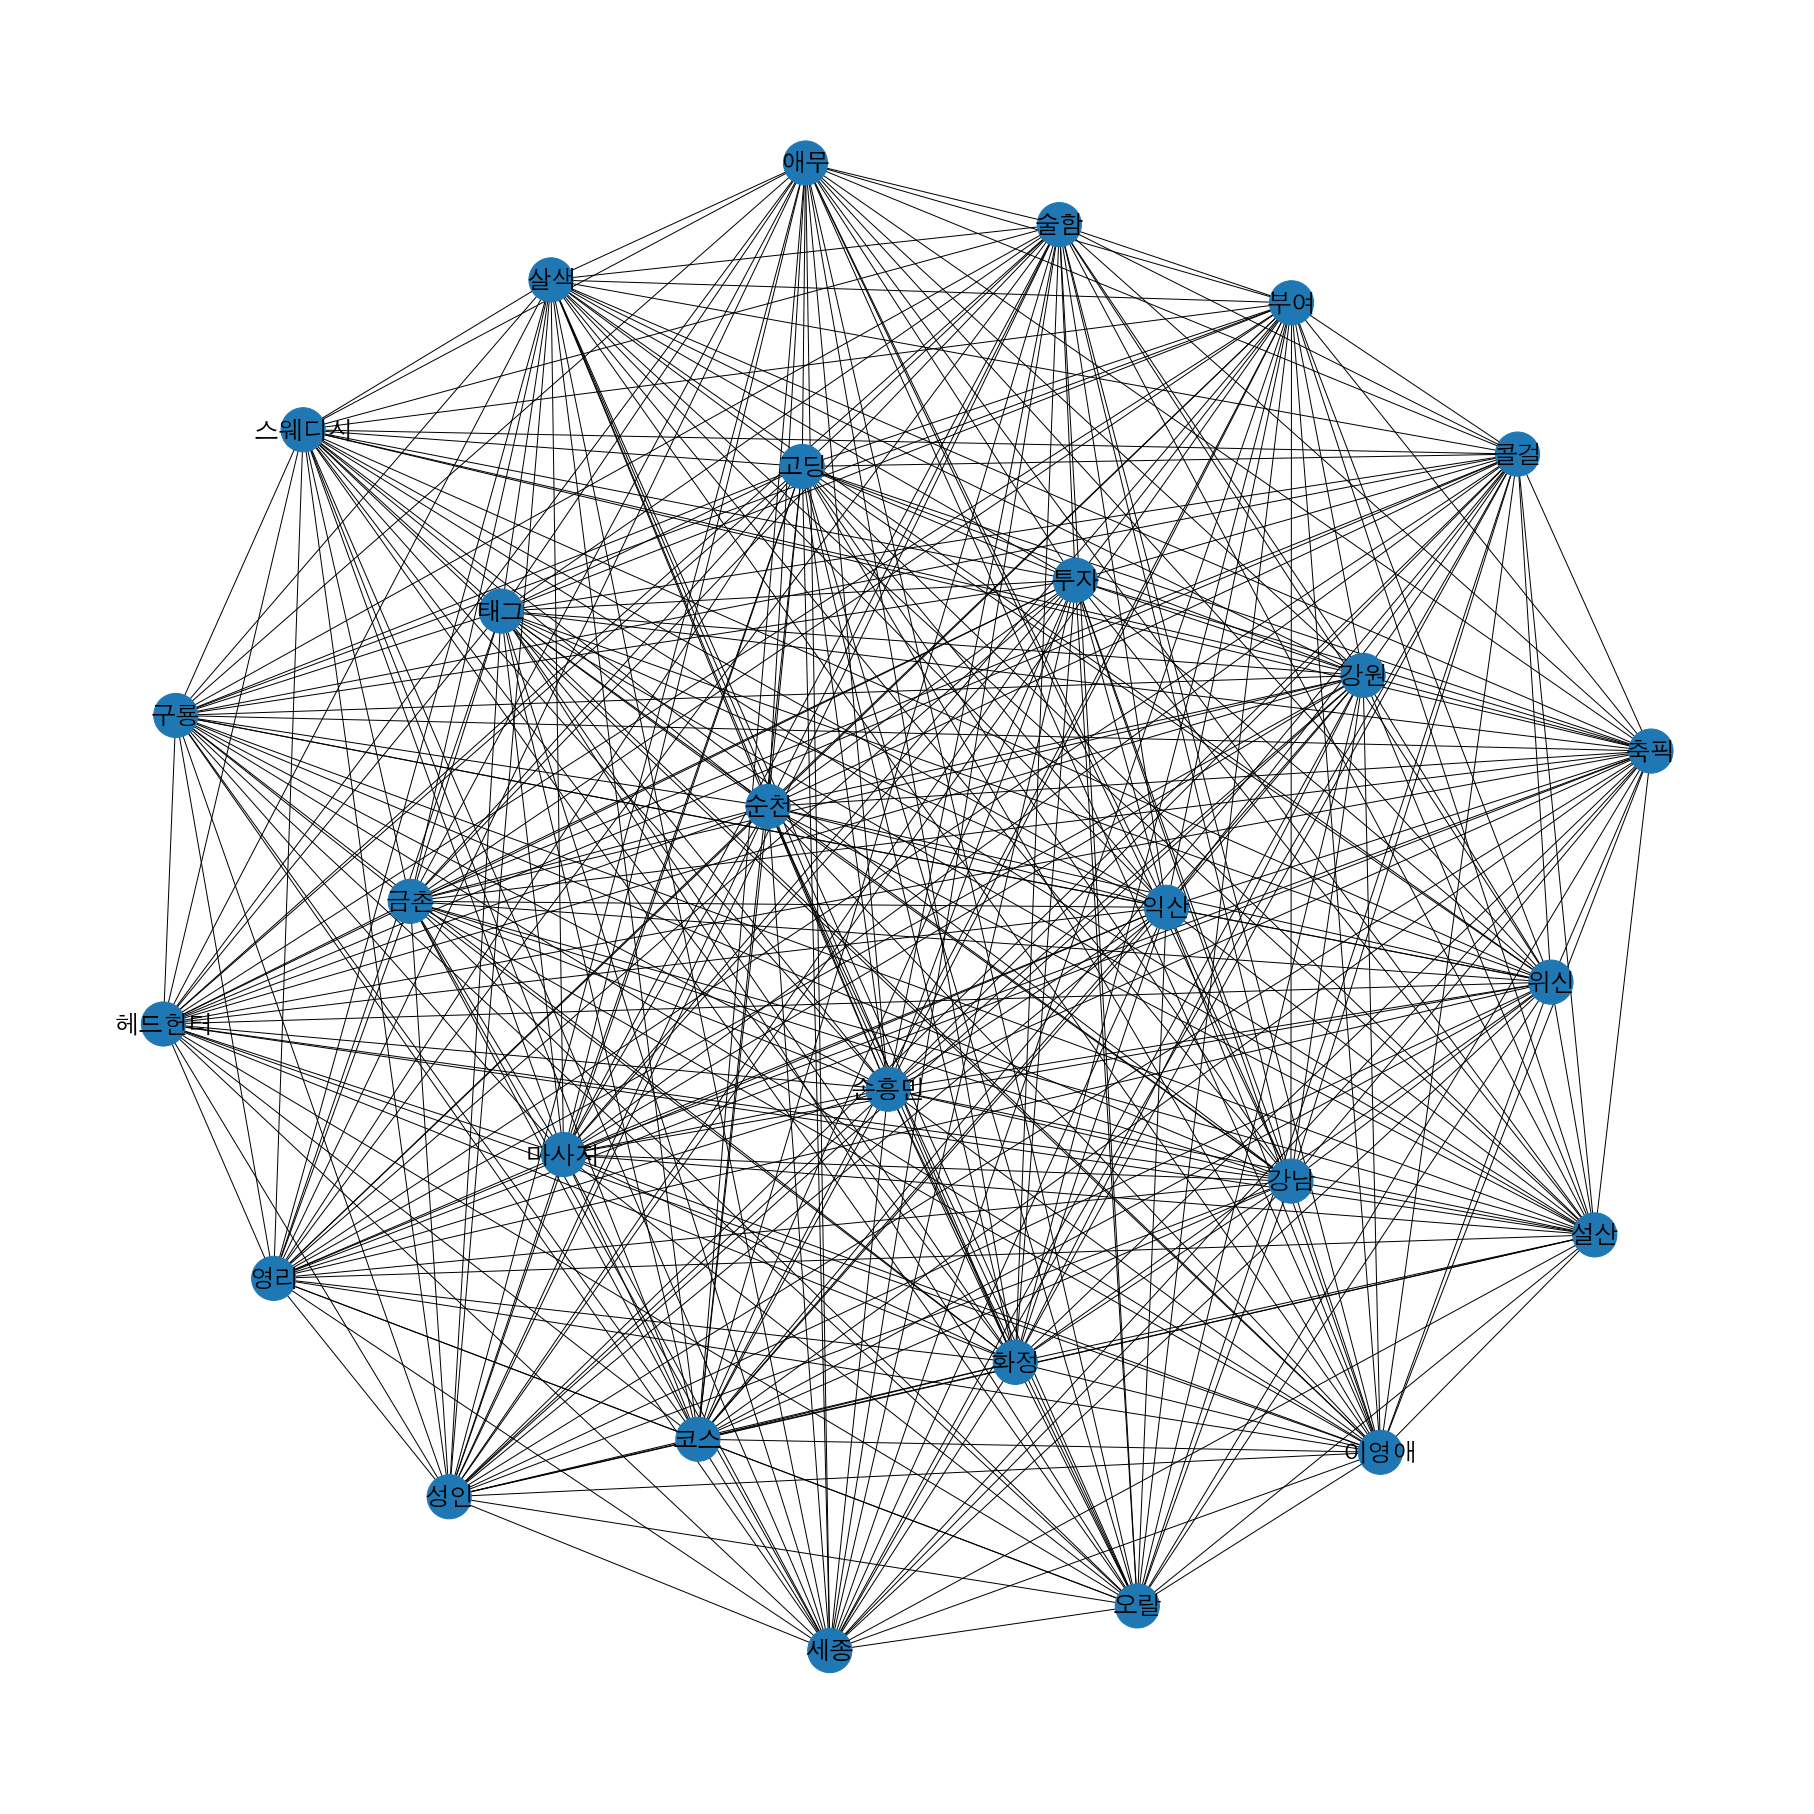

In [110]:
plt.figure(figsize=(25,25))
G = nx.Graph()
drawNetwork(G, node_df, plt)